# Modeling

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
from sklearn.metrics import roc_auc_score, roc_curve

import xgboost as xgb
from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import eli5
import shap
import pickle

import warnings
warnings.filterwarnings("ignore")

random_state = 17

In [3]:
data = pd.read_pickle('data/03_preprocessed.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316821 entries, 0 to 316821
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        316821 non-null  object        
 1   loan_amnt                 316821 non-null  int32         
 2   term                      316821 non-null  int32         
 3   int_rate                  316821 non-null  float64       
 4   installment               316821 non-null  float64       
 5   grade                     316821 non-null  int32         
 6   sub_grade                 316821 non-null  int32         
 7   emp_title                 316821 non-null  object        
 8   emp_length                316821 non-null  int32         
 9   home_ownership            316821 non-null  int32         
 10  annual_inc                316821 non-null  float64       
 11  verification_status       316821 non-null  int32         
 12  lo

# Train / Validation / Test

In [4]:
X = data.copy()

# simply impute 0 for col with missing values
# to improve for later iteration
cols_with_na = ['revol_util','mort_acc','pub_rec_bankruptcies']
for col in cols_with_na:
    X[col] = X[col].fillna(0)
    
drop_cols = ['id', 'emp_title', 'title', 'address', 'state', 'earliest_cr_line']
X = X.drop(columns=drop_cols)
y = X.pop('loan_status')

In [5]:
test_size = 0.2
val_size = 0.2

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=random_state)

print(f"Train: {X_train.shape[0]} samples, {X_train.shape[0]/X.shape[0]:.2%}, pos labels: {y_train.mean():.2%}")
print(f"Valid: {X_val.shape[0]} samples, {X_val.shape[0]/X.shape[0]:.2%}, pos labels: {y_val.mean():.2%}")
print(f"Test:  {X_test.shape[0]} samples, {X_test.shape[0]/X.shape[0]:.2%}, pos labels: {y_test.mean():.2%}")

Train: 190092 samples, 60.00%, pos labels: 84.23%
Valid: 63364 samples, 20.00%, pos labels: 84.18%
Test:  63365 samples, 20.00%, pos labels: 84.31%


In [6]:
train_data = pd.concat([X_train,y_train], axis='columns')
train_val_data = pd.concat([X_train_val, y_train_val], axis='columns') # train-val can be used to do Cross validation
val_data = pd.concat([X_val, y_val], axis='columns')
test_data = pd.concat([X_test, y_test], axis='columns')

## Save files

In [79]:
train_data.to_csv('data/train.csv', index=False)
train_val_data.to_csv('data/train_val.csv', index=False)
val_data.to_csv('data/valid.csv', index=False)
test_data.to_csv('data/test.csv', index=False)

# Feature Selection
Initial round

## Mutual Information Scores

Measure predictive power of *discrete* variables using non-parametric method.

In [8]:
# MI score helper
def make_mi_scores(X, y): #, discrete_features): 
    # let the function decide what is discrete variable automatically
	mi_scores = mutual_info_classif(X, y) #, discrete_features=discrete_features)
	mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
	mi_scores = mi_scores.sort_values(ascending=False)
	return mi_scores

In [9]:
mi_scores = make_mi_scores(X_train, y_train)
mi_scores

grade                       0.034311
int_rate                    0.032112
sub_grade                   0.031499
installment                 0.020046
home_ownership              0.019153
inc_verified                0.017224
verification_status         0.014521
installment_inc_ratio       0.013666
purpose                     0.012786
term                        0.012103
dti_q                       0.010653
home_mortgage               0.010056
dti                         0.008243
dti_adj                     0.007724
emp_length                  0.007606
home_rent                   0.007374
initial_list_status         0.006221
loan_amnt                   0.006153
annual_inc_q                0.006001
state_inc_med               0.004775
annual_inc_adj              0.004029
mort_acc                    0.003990
annual_inc                  0.003830
state_inc_rcv               0.003392
revol_util_adj              0.002890
mort_acc_adj                0.002827
revol_util                  0.002611
o

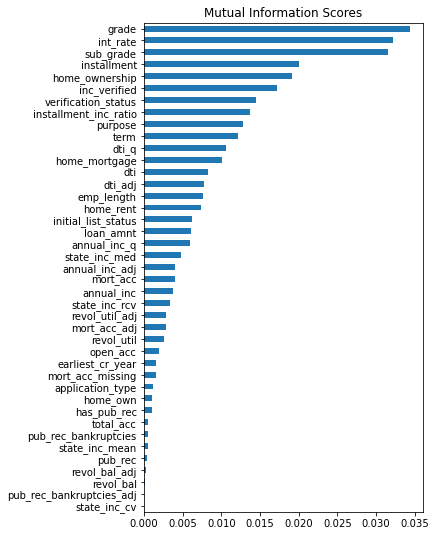

In [10]:
mi_scores.sort_values().plot.barh(figsize=(5,9), title='Mutual Information Scores');

## ANOVA Test

Continous predictors vs Categorical target.
(Just as a quick guideline, some variables are not from normal distribution)

In [11]:
cont_vars = ['loan_amnt','int_rate','installment','annual_inc','dti','open_acc','pub_rec','revol_bal','total_acc',
            'annual_inc_adj','installment_inc_ratio','dti_adj','revol_bal_adj','revol_util_adj','mort_acc_adj',
            'pub_rec_bankruptcies_adj','state_inc_med','state_inc_mean','state_inc_cv','state_inc_rcv']
f_stats, p_values = f_classif(X_train[cont_vars], y_train)

In [12]:
sig_levels = [ '***' if p < .01 else '**' if p < .05 else '*' if p < .1 else '' for p in p_values]
tab = pd.DataFrame({'col': cont_vars, 'p_value' : p_values, 'sig' : sig_levels }).sort_values('p_value')
tab

,col,p_value,sig
1,int_rate,0.000000e+00,***
11,dti_adj,0.000000e+00,***
4,dti,0.000000e+00,***
10,installment_inc_ratio,0.000000e+00,***
13,revol_util_adj,2.106026e-239,***
9,annual_inc_adj,1.460763e-202,***
0,loan_amnt,1.662372e-131,***
14,mort_acc_adj,1.217915e-115,***
3,annual_inc,5.184065e-114,***
2,installment,7.369420e-63,***


## Experiment: Fit with all features


In [13]:
# To address imbalanced
features = X_train.columns

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              #'max_depth': 3, 
              # 'booster':'gbtree',
              }


eval_set = [(X_train[features], y_train), (X_val[features], y_val)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_train[features], y_train, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_train, model.predict_proba(X_train[features])[:,1])
auc_val = roc_auc_score(y_val, model.predict_proba(X_val[features])[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features])[:,1])

print("All features")
print(f"Train ROC-AUC: {auc_train}")
print(f"Valid ROC-AUC: {auc_val}")
print(f"Test  ROC-AUC: {auc_test}")

All features
Train ROC-AUC: 0.7585697376413065
Valid ROC-AUC: 0.7211039924606344
Test  ROC-AUC: 0.7155748257121394


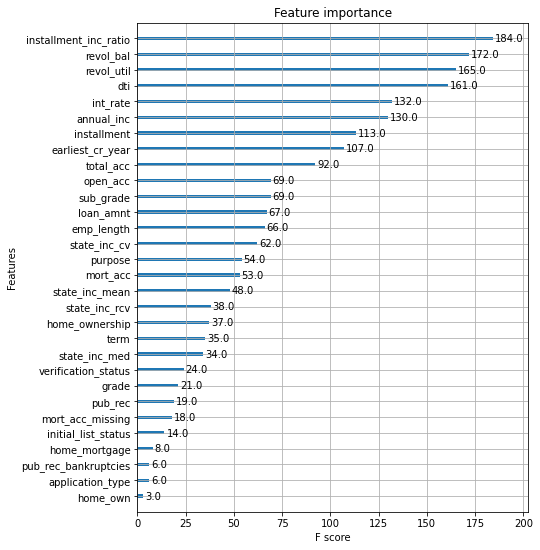

In [14]:
fig, ax = plt.subplots(figsize=(7,9))
plot_importance(model, ax=ax)
plt.show()

# Train Model

## Subset features

In [53]:
features = ['loan_amnt','term', 'int_rate', 'installment','grade', 'sub_grade',
            'emp_length', 'home_ownership', 'annual_inc',
            'verification_status',# 'inc_verified', 
            'purpose', 'dti', 'open_acc',
            'pub_rec','revol_bal','revol_util', 'total_acc',
            'initial_list_status', 
            'mort_acc','mort_acc_missing',
            'pub_rec_bankruptcies',
            'installment_inc_ratio',
            # 'earliest_cr_year', 
           ]
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              # 'booster':'gbtree',
              }
eval_set = [(X_train[features], y_train), (X_val[features], y_val)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_train[features], y_train, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_train, model.predict_proba(X_train[features])[:,1])
auc_val = roc_auc_score(y_val, model.predict_proba(X_val[features])[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features])[:,1])

print("Subset features")
print(f"Train ROC-AUC: {auc_train}")
print(f"Valid ROC-AUC: {auc_val}")
print(f"Test  ROC-AUC: {auc_test}")

Subset features
Train ROC-AUC: 0.7543993128123454
Valid ROC-AUC: 0.7218217901569642
Test  ROC-AUC: 0.7168786562710406


Less features with a bit improvement on validation and test set.

## Experiment: Resampling

Experiment with imbalanced handling methods

In [54]:
def experiment_resampler(resampler, name):

    X_train_rs, y_train_rs = resampler.fit_resample(X_train[features], y_train)
    X_train_rs = pd.DataFrame(X_train_rs, columns=X_train[features].columns)
    y_train_rs = pd.Series(y_train_rs, name=y_train.name)
    
    xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              # already equal weight
              # 'scale_pos_weight' : scale_pos_weight, 
              }

    eval_set = [(X_train_rs[features], y_train_rs), (X_val[features], y_val)]


    model = xgb.XGBClassifier(**xgb_params)
    model = model.fit(X_train_rs[features], y_train_rs, eval_set=eval_set, 
                    early_stopping_rounds=5, 
                    eval_metric='auc', verbose=False)
    auc_train = roc_auc_score(y_train_rs, model.predict_proba(X_train_rs[features])[:,1])
    auc_val = roc_auc_score(y_val, model.predict_proba(X_val[features])[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features])[:,1])
    print(f"Subset features + {name}")
    print(f"Train ROC-AUC: {auc_train}")
    print(f"Valid ROC-AUC: {auc_val}")
    print(f"Test  ROC-AUC: {auc_test}")
    return auc_train, auc_val, auc_test

In [55]:
rs_names = ['Under-sampling', 'Over-sampling', 'SMOTE']
resamplers = [
    RandomUnderSampler(random_state=random_state),
    RandomOverSampler(random_state=random_state),
    SMOTE(random_state=random_state)
]

for rs, name in zip(resamplers, rs_names):
    experiment_resampler(rs, name)
    print()


Subset features + Under-sampling
Train ROC-AUC: 0.763092402280583
Valid ROC-AUC: 0.7200552012298599
Test  ROC-AUC: 0.7119902829470738

Subset features + Over-sampling
Train ROC-AUC: 0.7527314694813857
Valid ROC-AUC: 0.7204684544588684
Test  ROC-AUC: 0.7141634719146998

Subset features + SMOTE
Train ROC-AUC: 0.9475141783593825
Valid ROC-AUC: 0.695620442083769
Test  ROC-AUC: 0.6921344801876438



None of the tested resampling helps.

## Tuning a bit

In [60]:
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              'n_estimators' : 500,
              'max_depth' : 4,
              'learning_rate' : .2,
              'reg_alpha' : 10,
              'reg_lambda' : 11,
              }

eval_set = [(X_train[features], y_train), (X_val[features], y_val)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_train[features], y_train, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_train, model.predict_proba(X_train[features])[:,1])
auc_val = roc_auc_score(y_val, model.predict_proba(X_val[features])[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features])[:,1])

print("Subset features + Parameters tuned")
print(f"Train ROC-AUC: {auc_train}")
print(f"Valid ROC-AUC: {auc_val}")
print(f"Test  ROC-AUC: {auc_test}")

Subset features + Parameters tuned
Train ROC-AUC: 0.7421543061785273
Valid ROC-AUC: 0.7247659868771624
Test  ROC-AUC: 0.7190465286518759


## Final Model

Use train+validation to train. 
The hyperparameters may work. Training with more data and hope that test set roc-auc will improve.

In [61]:
xgb_params = {'objective': 'binary:logistic', 
              'random_state': random_state,
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight,
              'n_estimators' : 500,
              'max_depth' : 4,
              'learning_rate' : .2,
              'reg_alpha' : 10,
              'reg_lambda' : 11,
              }

# not using the test set to evaluate, to make sure that test set is really untouched - No cheating!
eval_set = [(X_train_val[features], y_train_val)]
model = xgb.XGBClassifier(**xgb_params)
model = model.fit(X_train_val[features], y_train_val, eval_set=eval_set, 
                early_stopping_rounds=5, 
                eval_metric='auc', verbose=False)
auc_train = roc_auc_score(y_train_val, model.predict_proba(X_train_val[features])[:,1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test[features])[:,1])

print(f"Train ROC-AUC: {auc_train}")
print(f"Test  ROC-AUC: {auc_test}")

Train ROC-AUC: 0.7614963428933047
Test  ROC-AUC: 0.7202489356003132


## Save the final model and data

In [84]:
features_to_export = features + ['loan_status']

train_data[features_to_export].to_csv('data/train_final.csv', index=False)
train_val_data[features_to_export].to_csv('data/train_val_final.csv', index=False)
val_data[features_to_export].to_csv('data/valid_final.csv', index=False)
test_data[features_to_export].to_csv('data/test_final.csv', index=False)

# model.save_model('data/model.json')
with open('data/model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Test deliverables

In [85]:
# model2 = xgb.XGBClassifier()
# model2.load_model('data/model.json')
with open('data/model.pkl', 'rb') as f:
    model2 = pickle.load(f)

X_test2 = pd.read_csv('data/test_final.csv')
y_test2 = X_test2.pop('loan_status')

y_score2 = model2.predict_proba(X_test2)[:,1]
print(f"Test ROC-AUC: {roc_auc_score(y_test2, y_score)}")

Test ROC-AUC: 0.7202489356003132


# Performance metrics

Evaluate model performance on `Test Set`

In [99]:
from sklearn.metrics import classification_report

X_train = train_data[features]
y_train = train_data['loan_status']
X_test = test_data[features]
y_test = test_data['loan_status']

y_train_pred = model.predict(X_train)
y_train_score = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

## ROC Curve

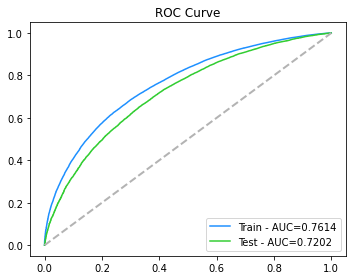

In [104]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
auc_train = roc_auc_score(y_train, y_train_score)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
auc_test = roc_auc_score(y_test, y_test_score)

fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
ax.plot(fpr_train, tpr_train, color='dodgerblue', label=f'Train - AUC={round(auc_train,4)}')
ax.plot(fpr_test, tpr_test, color='limegreen', label=f'Test - AUC={round(auc_test,4)}')
ax.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
ax.set_title('ROC Curve')
ax.legend(loc=4)
plt.show()

## Precision / Recall / F1

In [112]:
print('='*20, 'Train', '='*20)
print(classification_report(y_train, y_train_pred))
print('='*20, 'Test', '='*20)
print(classification_report(y_test, y_test_pred))

==================== Train ====================
              precision    recall  f1-score   support

           0       0.29      0.70      0.41     29982
           1       0.92      0.69      0.79    160110

    accuracy                           0.69    190092
   macro avg       0.61      0.69      0.60    190092
weighted avg       0.82      0.69      0.73    190092

==================== Test ====================
              precision    recall  f1-score   support

           0       0.27      0.64      0.38      9945
           1       0.91      0.67      0.78     53420

    accuracy                           0.67     63365
   macro avg       0.59      0.66      0.58     63365
weighted avg       0.81      0.67      0.71     63365



`Precision` should be what we focus and it's 0.91 on test set.

Since our positive label is 'Fully Paid', that means from the predicted positive borrowers, how many are classified as Fully Paid correctly.

This should also align with the business operation in a way that if they 'trust' the model and approve the loan requests for 100 customers, 91 customers are correctly classified as Fully Paid.

## Score distribution

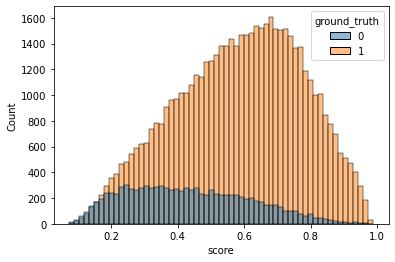

In [120]:
df = pd.DataFrame({'ground_truth' : y_test, 'score' : y_test_score})
sns.histplot(data=df, x='score', hue='ground_truth')
plt.show()

# Model Insights

## Feature Importance

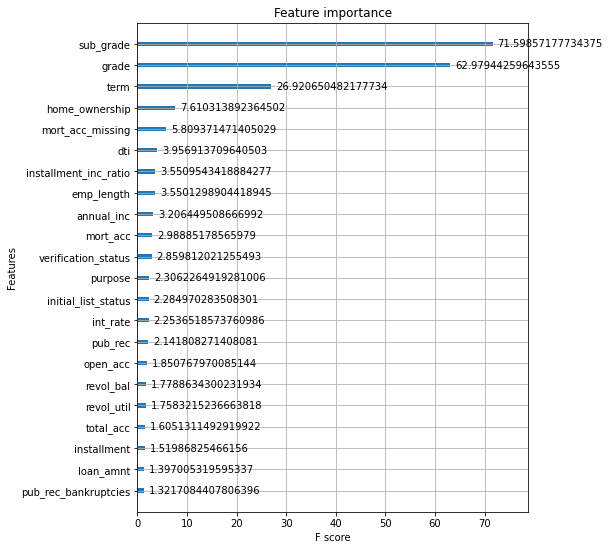

In [152]:
fig, ax = plt.subplots(figsize=(7,9))
plot_importance(model, ax=ax, importance_type='gain')
plt.show()

## Permutation Importance

In [131]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0304 ± 0.0006,revol_bal
0.0135 ± 0.0015,annual_inc
0.0128 ± 0.0014,installment
0.0099 ± 0.0013,mort_acc
0.0094 ± 0.0011,loan_amnt
0.0073 ± 0.0010,dti
0.0065 ± 0.0011,term
0.0056 ± 0.0006,installment_inc_ratio
0.0046 ± 0.0009,home_ownership
0.0041 ± 0.0012,revol_util


## SHAP

In [143]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

### Summary Plot

This plot explains a lot. Even though we use tree-based, the result here, for many features, show a clear direction - just like coefficients in linear models.

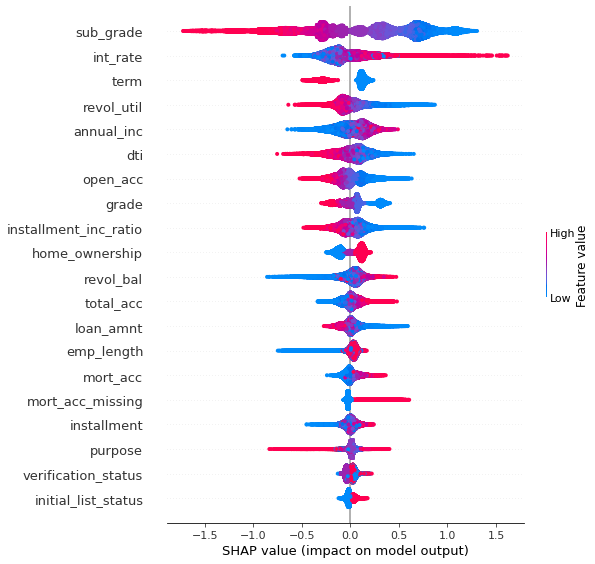

In [144]:
shap.summary_plot(shap_values, X_test)

### Mean SHAP Plot

For a brief explanation of feature impact on the probability. Same with summary plot but without direction.

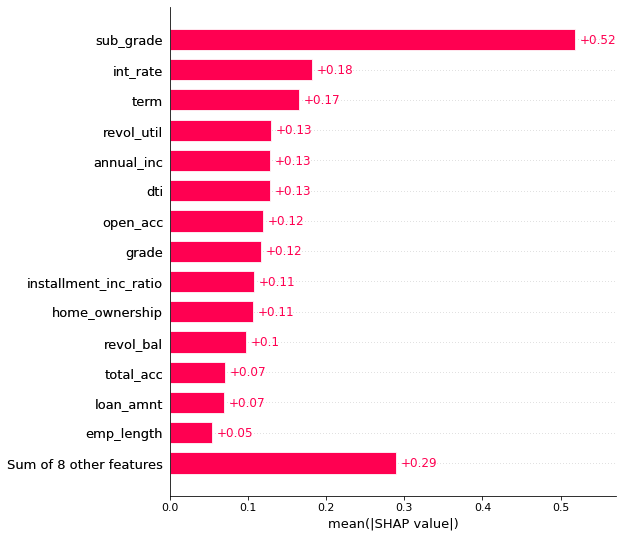

In [150]:
shap.plots.bar(explainer(X_test), max_display=15)